In [0]:
!apt-get install python-mvpa2 --fix-missing

In [0]:
from google.colab import drive
drive.mount("/content/drive")

In [7]:
%cd drive/My\ Drive

/content/drive/My Drive


In [0]:
!wget 'http://data.pymvpa.org/datasets/tutorial_data/tutorial_data-0.4.tar.gz'

In [0]:
!tar -xzf 'tutorial_data-0.4.tar.gz'

In [0]:
#minor modification in the function to make it work with the path in google colab

def load_tut_data(path=None, roi='brain', add_fa=None, flavor=None):
    """Loads the block-design demo dataset from PyMVPA dataset DB.
    Parameters
    ----------
    path : str, optional
      Path to the directory with the extracted content of the tutorial
      data package. This is only necessary for accessing the full resolution
      data. The ``1slice``, and ``25mm`` flavors are shipped with PyMVPA
      itself, and the path argument is ignored for them. This function also
      honors the MVPA_LOCATION_TUTORIAL_DATA environment variable, and the
      respective configuration setting.
    roi : str or int or tuple or None, optional
      Region Of Interest to be used for masking the dataset. If a string is
      given a corresponding mask image from the demo dataset will be used
      (mask_<str>.nii.gz). If an int value is given, the corresponding ROI
      is determined from the atlas image (mask_hoc.nii.gz). If a tuple is
      provided it may contain int values that a processed as explained
      before, but the union of a ROIs is taken to produce the final mask.
      If None, no masking is performed.
    add_fa : dict, optional
      Passed on to the dataset creator function (see fmri_dataset() for
      more information).
    flavor: str, optional
      Resolution flavor of the data to load. By default, the data is loaded in
      its original resolution. The PyMVPA source distribution contains a '25mm'
      flavor that has been downsampled to a very coarse resolution and can be
      used for quick test execution. Likewise a ``1slice`` flavor is available
      that contents a full-resultion single-slice subset of the dataset.
    """
    
    path = '/content/drive/My Drive/tutorial_data/'
    if path is None:
        if flavor in ('1slice', '25mm'):
            # we know that this part is there
            path = pathjoin(pymvpa_dataroot)
        else:
            # check config for info, pretend it is in the working dir otherwise
            path = mvpa2.cfg.get('location',
                                 'tutorial data',
                                 default=os.path.curdir)
    # we need the haxby2001 portion of the tutorial data
    path = pathjoin(path, 'data')
    
    import nibabel as nb
    from mvpa2.datasets.sources.openfmri import OpenFMRIDataset
    model = subj = 1
    dhandle = OpenFMRIDataset(path)
    if flavor is None:
        maskpath = pathjoin(path, 'sub001', 'masks', 'orig')
    else:
        maskpath = pathjoin(path, 'sub001', 'masks', flavor)
    if roi is None:
        mask = None
    elif isinstance(roi, str):
        mask = pathjoin(maskpath, roi + '.nii.gz')
    elif isinstance(roi, int):
        nimg = nb.load(pathjoin(maskpath, 'hoc.nii.gz'))
        tmpmask = nimg.get_data() == roi
        mask = nb.Nifti1Image(tmpmask.astype(int), nimg.affine, nimg.header)
    elif isinstance(roi, (tuple, list)):
        nimg = nb.load(pathjoin(maskpath, 'hoc.nii.gz'))
        tmpmask = np.zeros(nimg.shape, dtype='bool')
        for r in roi:
            tmpmask = np.logical_or(tmpmask, nimg.get_data() == r)
        mask = nb.Nifti1Image(tmpmask.astype(int), nimg.affine, nimg.header)
    elif isinstance(roi, nb.Nifti1Image):
        mask = roi
    else:
        raise ValueError("Got something as mask that I cannot handle.")
    ds = dhandle.get_model_bold_dataset(model, subj, flavor=flavor,
                                        mask=mask, add_fa=add_fa,
                                        noinfolabel='rest')
    # fixup time_coords to make the impression of a continuous time series
    # this is only necessary until we have changed the tutorial to
    # show/encourage run-wise processing
    ds.sa['time_coords'] = np.linspace(0, (len(ds) * 2.5), len(ds) + 1)[:-1]
    return ds

In [0]:
from mvpa2.suite import *
ds = load_tut_data(roi=(36,38,39,40))

In [19]:
# detrend on full timeseries
poly_detrend(ds, polyord=1, chunks_attr='chunks')

/usr/lib/python2.7/dist-packages/mvpa2/mappers/detrend.py:325: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit = np.linalg.lstsq(regs, ds.samples)


In [0]:
orig_ds = ds.copy()

In [0]:
zscore(ds, chunks_attr='chunks', param_est=('targets', 'rest'))

In [0]:
events = find_events(targets=ds.sa.targets, chunks=ds.sa.chunks)

In [0]:
# filter out events
events = [ev for ev in events if ev['targets'] in ['house', 'face']]

# modify event start and set uniform duration
for ev in events:
    ev['onset'] -= 2
    ev['duration'] = 13

In [24]:
evds = eventrelated_dataset(ds, events=events)

/usr/lib/python2.7/dist-packages/mvpa2/mappers/boxcar.py:55: FutureWarning: Conversion of the second argument of issubdtype from `'i'` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype('i').type`.
  if np.issubdtype(startpoints.dtype, 'i'):


In [25]:
clf = LinearCSVMC()
sclf = SplitClassifier(clf, enable_ca=['stats'])

# Compute sensitivity, which internally trains the classifier
analyzer = sclf.get_sensitivity_analyzer()
sensitivities = analyzer(evds)

/usr/lib/python2.7/dist-packages/mvpa2/misc/attrmap.py:153: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.string_ == np.dtype(str).type`.
  if not np.issubdtype(attr.dtype, str) and not self.mapnumeric:
/usr/lib/python2.7/dist-packages/mvpa2/clfs/libsvmc/svm.py:215: FutureWarning: Conversion of the second argument of issubdtype from `'c'` to `str` is deprecated. In future, it will be treated as `np.string_ == np.dtype('c').type`.
  if ( np.issubdtype(self.ca.trained_targets.dtype, 'c') or


In [26]:
print sclf.ca.stats


----------.
predictions\targets  face   house
            `------  -----  ----- P' N' FP FN PPV NPV TPR SPC FDR MCC F1 AUC
        face          12      0   12 12  0  0  1   1   1   1   0   1   1  1
       house           0     12   12 12  0  0  1   1   1   1   0   1   1  1
Per target:          -----  -----
         P            12     12
         N            12     12
         TP           12     12
         TN           12     12
Summary \ Means:     -----  ----- 12 12  0  0  1   1   1   1   0   1   1  1
       CHI^2          24   p=2.5e-05
        ACC            1
        ACC%          100
     # of sets        12    ACC(i) = 1+0*i p=1 r=0 r^2=0



In [0]:
example_voxels = [(28,25,25), (28,23,25)]

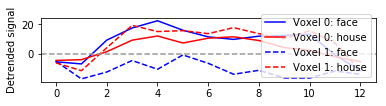

In [28]:
vx_lty = ['-', '--']
t_col = ['b', 'r']

pl.subplot(311)
for i, v in enumerate(example_voxels):
    slicer = np.array([tuple(idx) == v for idx in ds.fa.voxel_indices])
    evds_detrend = eventrelated_dataset(orig_ds[:, slicer], events=events)
    for j, t in enumerate(evds.uniquetargets):
        pl.plot(np.mean(evds_detrend[evds_detrend.sa.targets == t], axis=0),
               t_col[j] + vx_lty[i],
               label='Voxel %i: %s' % (i, t))
pl.ylabel('Detrended signal')
pl.axhline(linestyle='--', color='0.6')
pl.legend()

Text(0.5,0,'Peristimulus volumes')

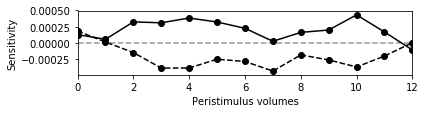

In [29]:
pl.subplot(313)
smaps = evds.a.mapper[-1].reverse(sensitivities)

for i, v in enumerate(example_voxels):
    slicer = np.array([tuple(idx) == v for idx in ds.fa.voxel_indices])
    smap = smaps.samples[:,:,slicer].squeeze()
    plot_err_line(smap, fmt='ko', linestyle=vx_lty[i])
pl.xlim((0,12))
pl.ylabel('Sensitivity')
pl.axhline(linestyle='--', color='0.6')
pl.xlabel('Peristimulus volumes')

